## Interactive session

We are about to load a Chlorophyll data set. We have to remove the trend and subtract the monthly climatologies. We want to plot a panel of maps showing lead/lag correlations with the ENSO index.

In [1]:
%matplotlib inline
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
from scipy.signal import detrend
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['font.size'] = 20

# define a function that subtracts the mean along the "time" dimension
def subtract(x):
    return x - x.mean(dim="time")

# define our custom detrend function that also fills NaNs with 0s
def detrend_(x):
    return detrend(x.fillna(0),axis=0)

**Q-1** Load the ENSO index from the recently created NetCDF file (`our_enso.nc`)

In [2]:
ds_pc = xr.open_dataset("our_enso.nc")

**Q-2** Pre-processing the chlorophyll dataset
1. Open the chlorophyll data set as an `xarray` dataset and inspect it using `display()`
2. Pick a location and plot the monthly climatology
3. Detrend the dataset and subtract the monthly climatology and check if the climatology has been removed
4. What time period is covered by both datasets?
5. Select a subset of the ENSO data for this shorter time period (*Hint: A select a subset using `.sel()` and `slice()` to define start and end points for a selection.*)

<xarray.Dataset>
Dimensions:  (time: 312, lon: 360, lat: 181)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2018-12-16T12:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    chl      (time, lat, lon) float32 ...
Attributes: (12/18)
    CDI:                           Climate Data Interface version 1.9.10 (htt...
    Conventions:                   CF-1.6
    source:                        MERCATOR FREEBIORYS2V4
    institution:                   Mercator Ocean
    product:                       GLOBAL_REANALYSIS_BIO_001_029
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    licence:                       http://marine.copernicus.eu/services-portf...
    dataset:                       global-reanalysis-bio-001-029-monthly
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    history:                       Tue Aug 17 09:56:50 2021: cdo -remapcon,r3...
    CDO:                           Climate Data Operators version 1.9.10 (htt...

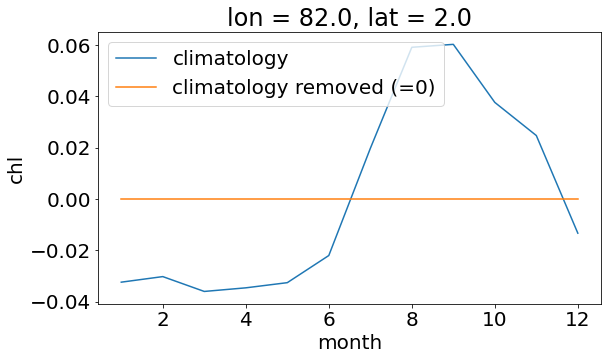

In [3]:
ds_chl = xr.open_dataset("global-reanalysis-bio-001-029-monthly_1993-2018_1deg.nc").squeeze("depth").drop("depth")
display(ds_chl)
# ds_chl = ds_chl.rename({'lat': 'latitude', 'lon': 'longitude'}).set_coords(['longitude', 'latitude', 'time'])
var = "chl"
varname = "Chlorophyll"

ds0_chl = ds_chl*1.0
ds_chl = ds_chl.apply(detrend_)
ds1_chl = ds_chl*1.0
ds_chl = ds_chl.groupby("time.month").apply(subtract)
ds2_chl = ds_chl*1.0

ds1_chl[var].groupby("time.month").mean().sel(lon=82,lat=2).plot(label="climatology")
ds2_chl[var].groupby("time.month").mean().sel(lon=82,lat=2).plot(label="climatology removed (=0)")
plt.legend();

In [4]:
display(ds_pc["time"])
display(ds_chl["time"])
t1 = "1993-01-16"
t2 = "2018-12-16"
ds_pc = ds_pc.sel(time=slice(t1,t2))
display(ds_pc)

<xarray.DataArray 'time' (time: 863)>
array([cftime.Datetime360Day(1949, 10, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.Datetime360Day(1949, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.Datetime360Day(1949, 12, 16, 0, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.Datetime360Day(2021, 6, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.Datetime360Day(2021, 7, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.Datetime360Day(2021, 8, 16, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1949-10-16 00:00:00 ... 2021-08-16 00:00:00

<xarray.DataArray 'time' (time: 312)>
array(['1993-01-16T12:00:00.000000000', '1993-02-15T00:00:00.000000000',
       '1993-03-16T12:00:00.000000000', ..., '2018-10-16T12:00:00.000000000',
       '2018-11-16T00:00:00.000000000', '2018-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2018-12-16T12:00:00
Attributes:
    standard_name:  time
    long_name:      Time (hours since 1950-01-01)
    axis:           T

<xarray.Dataset>
Dimensions:  (time: 312)
Coordinates:
  * time     (time) object 1993-01-16 00:00:00 ... 2018-12-16 00:00:00
Data variables:
    PC       (time) float32 ...

**Q-3** Compute and visualize a correlation map of Chlorophyll and ENSO. What do you see?

(312, 181, 360)
(312,)


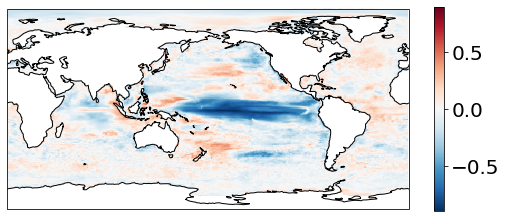

In [5]:
# extract values
data_all = ds_chl[var].values
pc1 = ds_pc.to_array().squeeze().values

print(data_all.shape)
print(pc1.shape)

nt, ny, nx = data_all.shape
data_all = np.reshape(data_all,(nt,ny*nx))

# define projections
proj = ccrs.PlateCarree(central_longitude=180)
data_proj = ccrs.PlateCarree()

fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj})
ax.coastlines()

x = (pc1/pc1.std(axis=0)).T
y = data_all/data_all.std(axis=0)
# the  matrix multiplication method
X = np.dot(x,y)/nt
# back to lon/lat shape
data_eof_regr = np.reshape(X,(ny,nx))
coords = [("latitude", ds_chl["lat"].data),("longitude", ds_chl["lon"].data)]
eof_maps = xr.DataArray(data_eof_regr, coords=coords)
eof_maps.plot(ax=ax,transform=data_proj,add_colorbar=True,cbar_kwargs={"shrink": 0.75});

**Q-4** *[bonus points]* Compute the correlation map for lead/lags from -12 months to +12 months.

In [6]:
fig, axes = plt.subplots(3,3,subplot_kw={'projection':proj},sharex=True,sharey=True,figsize=(14,8))
axes = axes.flatten()

lags = [12,9,6,3,0,-3,-6,-9,-12]
for i,lag in enumerate(lags):
    axes[i].coastlines()
    if lag > 0:
        x = (pc1[lag:]/pc1[lag:].std()).T
        y = data_all[:-lag,:]/data_all[:-lag,:].std(axis=0)
        axes[i].set_title("%s leads by %d months"%(varname,lag),loc="left",fontsize=12)
    elif lag < 0:
        x = (pc1[:lag]/pc1[:lag].std()).T
        y = data_all[-lag:,:]/data_all[-lag:,:].std(axis=0)
        axes[i].set_title("ENSO leads by %d months"%(-lag),loc="left",fontsize=12)
    else:
        x = (pc1/pc1.std(axis=0)).T
        y = data_all/data_all.std(axis=0)
        axes[i].set_title("lead/lag = 0",loc="left",fontsize=12)
    X = np.dot(x,y)/(nt-np.abs(lag))
    data_eof_regr = np.reshape(X,(ny,nx))
    eof_maps = xr.DataArray(data_eof_regr, coords=coords)
    eof_maps.plot(ax=axes[i],transform=data_proj,cmap='RdBu_r',vmin=-1,vmax=1,add_colorbar=False)
fig.tight_layout()
fig.savefig("images/chl_lead-lag_correlations.png",dpi=300)
plt.close()

<img src="images/chl_lead-lag_correlations.png" width="1200" align="center">